The `ModelOptimizer` should take any cv methods, custom scorer and optimization configurations. It then return the optimization results, which can be utilized to train the optimal `ModelPipeline` object to be saved for consumption.  

The main optimizer it can leverage now are
* FeatureSelector
* HyperparamsTuner
It also leverages the CustomTransformer for data preprocessing. 

The `ModelOptimizer` saves loads of info of the optimizing process for diagnostic purpose. In contrast, the `ModelPipeline` object should be light, with minimal info needed for consumption. 

In [1]:
import lightgbm as lgb
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import RFECV
from mlops_class import CustomTransformer,ModelPipeline, FeatureSelector, MLUtils
import pandas as pd
import numpy as np

In [2]:
class ModelOptimizer:

    def __init__(self, 
                 model_params, 
                 feature_selector_params,
                 custom_transformer_params,
                 scorer=None,
                 cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42)):

        self.model_params = model_params
        self.feature_selector_params = feature_selector_params
        self.custom_transformer_params = custom_transformer_params
        self.cv = cv
        self.scorer = scorer
    
    
    def optimize(self, task, X, y):
        """Optimize based on the CV Optimizer configerations

        Args:
            tasK: the optimizing task, such as feature_selection or hyperparams_tuning
            X (df): the features
            y (array): the target

        Returns:
            best_set: best_feature_set for FeatureSelector, best_hyperms_set for HypermsTuner
        """
        
        custom_transformer = CustomTransformer(**self.custom_transformer_params)
        estimator = self.model_params['estimator']
        scorer = self.scorer
        
        if task == 'feature_selection':
            selected_features_all_folds = []
            outer_loop_log = {}
            test_scores = []
            self.feature_selectors = []
            
            
            for i, (train_idx, test_idx) in enumerate(self.cv.split(X,y)):

                #LEARNING: define feature_selector within this loop, otherwise the feature_selectors 
                # will only be able to capture the last feature_selector 
                feature_selector = FeatureSelector(
                    estimator = estimator,
                    cv = self.cv,
                    scorer = self.scorer,
                    **self.feature_selector_params
                )                
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]
                
                X_train_transformed = custom_transformer.fit_transform(X_train)
                X_test_transformed = custom_transformer.transform(X_test)                
                # Perform feature selection using the inner cross-validation
                selected_features, inner_score = feature_selector.select_features(X_train_transformed, y_train)
                # Train the estimator on the selected features
                estimator.fit(X_train_transformed[selected_features], y_train)
                # Evaluate the estimator on the test set
                score = self.scorer(estimator, X_test_transformed[selected_features], y_test)
                
                outer_loop_log[f'fold_{i}'] = {}
                outer_loop_log[f'fold_{i}']['test_score'] = score
                outer_loop_log[f'fold_{i}']['inner_cv_score'] = inner_score
                outer_loop_log[f'fold_{i}']['best_features'] = selected_features
                print(f"max for inner cv: {feature_selector.rfecv.cv_results_['mean_test_score'].max():3f}")
                self.feature_selectors.append(feature_selector)
                test_scores.append(score)
                selected_features_all_folds.append(selected_features)
                # print(f'fold {i} test score is {score:.3} achieved by {len(selected_features)} features')
                
            # save the best feature set with the highest test_score
            best_set = MLUtils.get_best_fold(outer_loop_log, 'test_score', 'best_features')
            # save the feature_selector that return the highest test_score
            # print(f"the fold that achieve the best test score is {test_scores.index(max(test_scores))}")
            self.feature_selector = self.feature_selectors[test_scores.index(max(test_scores))]
            # loop_log = outer_loop_log
            # score_best = max(test_scores)
            # score_std = np.std(test_scores)        
        
        if task == 'hyperparams_tuning':
            pass
            #TODO utlize hyperparams_tuner to get the best hyperparams set
            # we can either call it once the best feature set is identified based on default hyperparams set
            # or for each hyperparams set get the best feature set

        return best_set

# Config the ModelOptimizer

In [3]:
# Example usage
# Create a sample dataset for demonstration
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns = data.feature_names)
y = data.target

In [4]:
# Configure the optimizer
# Define outer and inner cross-validation strategies
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
custom_scorer = make_scorer(MLUtils.gini_scorer, greater_is_better=True, needs_proba=True)
custom_transformer_params = {
    'bin_features': [],
    'num_features': X.select_dtypes(include = 'number').columns.tolist(),
    'cat_features': X.select_dtypes(exclude = 'number').columns.tolist()
    }
model_params = {
    'estimator': lgb.LGBMClassifier(verbose=-1),
    'hyperparams_space': {}
}
feature_selector_params = {
    'min_features_to_select': 5
}


## Feature Selection

In [5]:
custom_optimizer = ModelOptimizer(cv=cv,
                                  scorer = custom_scorer,
                                  model_params=model_params,
                                  feature_selector_params=feature_selector_params,
                                  custom_transformer_params=custom_transformer_params
                              )

In [6]:
best_features = custom_optimizer.optimize(task='feature_selection', X=X,y=y)
print(f"Among all {X.shape[1]} features, {len(best_features)} features were selected, which include {best_features}")

max for inner cv: 0.978067
max for inner cv: 0.986354
max for inner cv: 0.991744
max for inner cv: 0.990093
max for inner cv: 0.979780
The best score is 0.999, and the std is 0.0101
Among all 30 features, 26 features were selected, which include ['mean radius', 'mean texture', 'mean perimeter', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'area error', 'smoothness error', 'compactness error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry']


the max test score is 0.978 achieved with 26 features


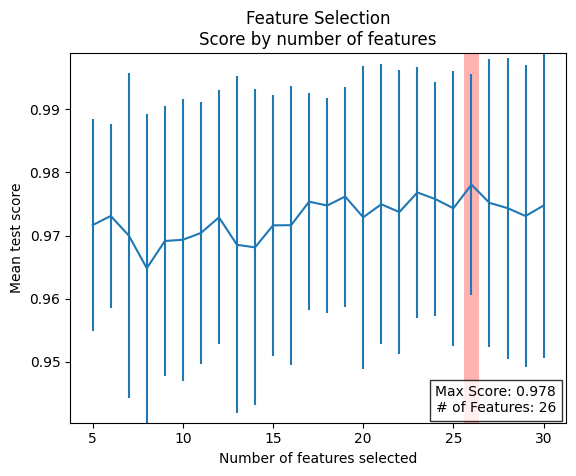

In [7]:
custom_optimizer.feature_selector.feature_score_plot()

In [8]:
# the ModelOptimizer object contains information of feature_selector in all folds
custom_optimizer.feature_selectors[1].rfecv.cv_results_["mean_test_score"]

array([0.98263407, 0.97932393, 0.9801547 , 0.9799483 , 0.97870991,
       0.98345449, 0.98387246, 0.98469288, 0.98222645, 0.98408145,
       0.98304687, 0.98429561, 0.98367383, 0.98594938, 0.98470582,
       0.98615061, 0.98635442, 0.98573005, 0.98449942, 0.98408403,
       0.98263925, 0.98449683, 0.98429561, 0.98429561, 0.98491222,
       0.98243285])